In [1]:
import umap.plot
import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import ExtraTreesClassifier
from treeinterpreter import treeinterpreter as ti
import numpy as np
from joblib import load
import pandas as pd

import scienceplots
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use(['science', 'ieee'])


# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
# })

window = "15min"
psd_columns = ["nice/marker/PowerSpectralDensity/alpha",
               "nice/marker/PowerSpectralDensity/beta",
               "nice/marker/PowerSpectralDensity/delta",
               "nice/marker/PowerSpectralDensity/gamma",
               "nice/marker/PowerSpectralDensity/theta"]

2023-08-24 17:49:13.162910: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 17:49:13.186341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 17:49:13.559500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#
# --- predict over time ---
#
seeg_features = pd.read_csv(
    f"../../data/processed/seeg_features_epochs_{window}.csv", index_col=[0, 1, 2], header=[0, 1, 2])
seeg_features = seeg_features.drop(columns=psd_columns).dropna()

out_path = f"../../data/processed/clis_features_epoch_{window}.csv"
epochs_features = pd.read_csv(out_path, header=[0, 1, 2], index_col=0)[
    seeg_features.columns]
epochs_features.index = pd.DatetimeIndex(epochs_features.index)
epochs_features.columns.names = list(
    map(lambda x: x.replace("fun", "function"), epochs_features.columns.names))

<ipython-input-2-20ff7e82a108>:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  seeg_features = seeg_features.drop(columns=psd_columns).dropna()


In [3]:
df_pred_plot = pd.DataFrame(index=epochs_features.index)
clf = ExtraTreesClassifier(
    n_estimators=2000, max_features=1, max_depth=4, criterion="entropy", n_jobs=-1)
X = seeg_features.interpolate().values
y = pd.Series(seeg_features.index.get_level_values(1)).replace(
    {"conscious": 1, "unconscious": 0}).values
clf.fit(X, y)

ExtraTreesClassifier(criterion='entropy', max_depth=4, max_features=1,
                     n_estimators=2000, n_jobs=-1)

In [4]:
prediction, bias, contributions = ti.predict(clf, epochs_features.values)

In [5]:
df_pred_ = pd.DataFrame(prediction, columns=clf.classes_,
                        index=epochs_features.index)
df_pred = df_pred_.rolling("5min").mean()

<Figure size 640x480 with 0 Axes>

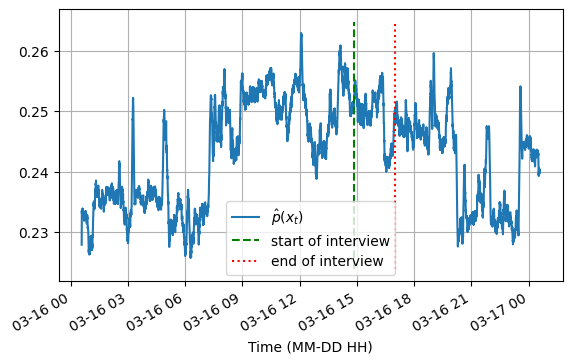

In [6]:
start = pd.Timestamp("2008-03-16 14:50:00")
end = pd.Timestamp("2008-03-16 17:00:00")
# ax = df_pred_plot.plot(figsize=(15, 5), alpha=0.15, color="grey", legend=False)
plt.clf()
fig, ax = plt.subplots(figsize=(6.5, 4))

ax = df_pred[1].rename("$\hat{p}(x_{t})$").plot()
ymin, ymax = ax.get_ylim()
ax.set_xlabel("Time (MM-DD HH)")
# ax.xaxis.set_major_formatter(ticker.FixedFormatter([item.strftime('%H:%M') for item in df_pred.index]))
# plt.gcf().autofmt_xdate()
ax.vlines(x=start, ymin=ymin, ymax=ymax, color="g",
          linestyles="dashed", label="start of interview")
ax.vlines(x=end, ymin=ymin, ymax=ymax, color="r",
          linestyles="dotted", label="end of interview")
plt.legend()
plt.grid()
plt.show()

In [8]:
# top_n = 48
top_n = 10
vertical = False
if vertical:
    fsize = (12, 4)
else:
    fsize = (3, 8)

df_contributions = pd.DataFrame(
    contributions[:, :, 1], index=epochs_features.index, columns=epochs_features.columns)
df_contributions.columns = pd.MultiIndex.from_tuples(
    [("/".join(x.split("/")[2:]), y, z) for x, y, z in epochs_features.columns])
df_contributions.columns.names = epochs_features.columns.names
#df_contr = df_contributions.resample("1min").mean(
#).iloc[:, np.argsort(df_contributions.std(axis=0).values)[::-1]]

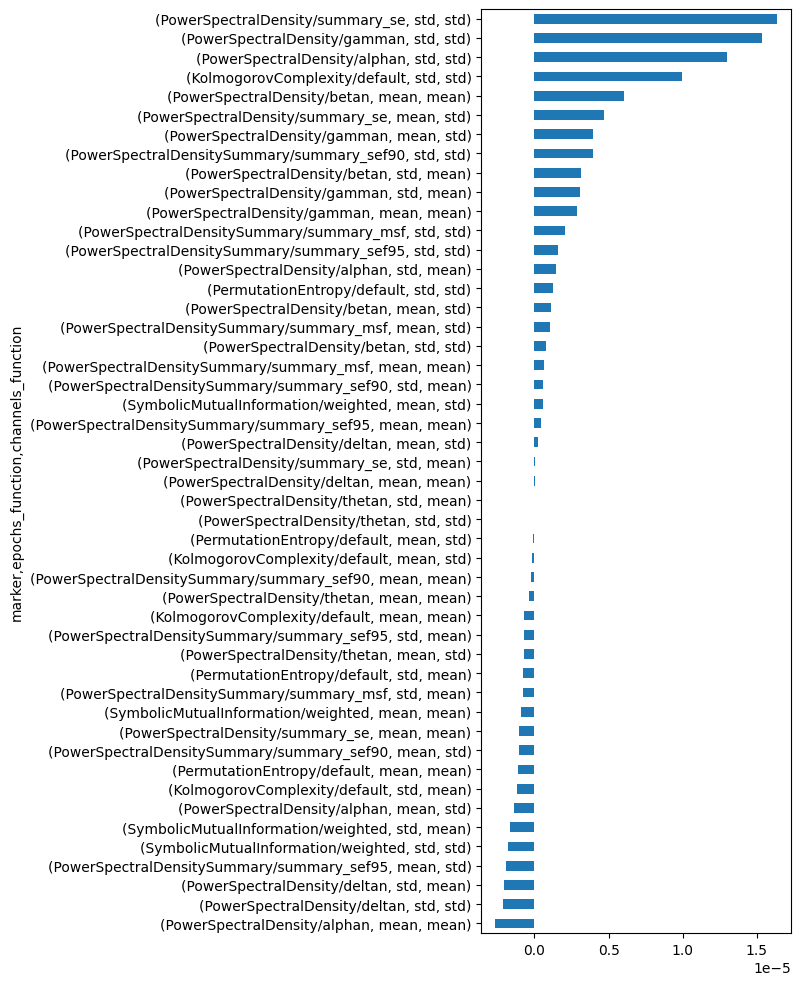

In [9]:
cov = pd.Series(np.cov(df_contributions.values,
             df_pred[1].values.reshape(1, -1), rowvar=False)[:-1, -1], index=df_contributions.columns)
cov.sort_values().plot.barh(figsize=(4, 12))
# sort contributions by covariance with total prediction to identify markers most relevant
df_contr = df_contributions.resample("1min").mean().iloc[:, np.argsort(cov)[::-1]]

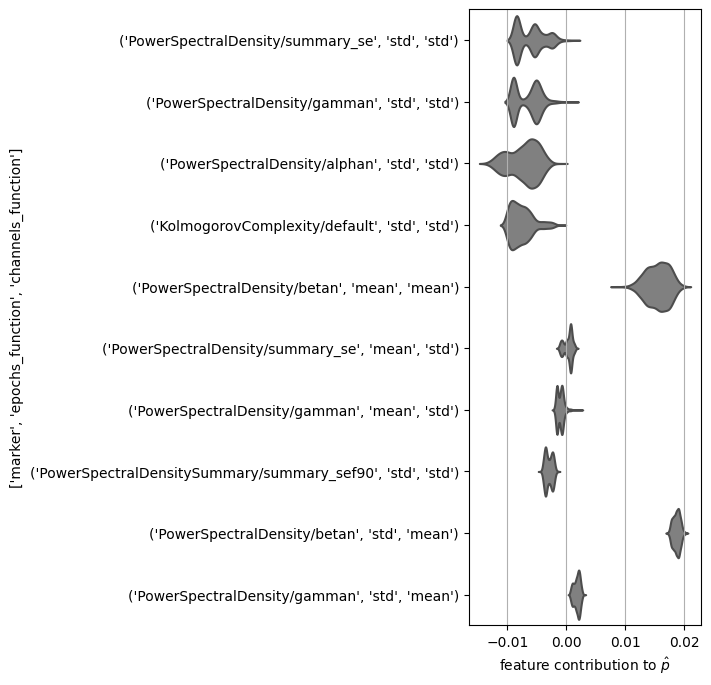

In [11]:
plt.figure(figsize=(3, 8))
plt.grid()
ax = sns.violinplot(
    df_contr.iloc[:, :top_n], orient="h", inner=None, scale="width", color="grey")
# ax = sns.violinplot(df_contr, orient="h", inner=None, scale="width", color="grey")
ax.set_xlabel("feature contribution to $\hat{p}$")
ax.set_ylabel(df_contr.columns.names)
fig = ax.get_figure()

In [12]:
# umap
scaled_epochs_features = pd.DataFrame(StandardScaler().fit_transform(
    epochs_features), index=epochs_features.index, columns=epochs_features.columns)

In [13]:
mapper = umap.UMAP(n_neighbors=2*60).fit(scaled_epochs_features)

Text(0.5, 1.0, 'UMAP embedding of CLIS feature dataset: points during interview colored red (1)')

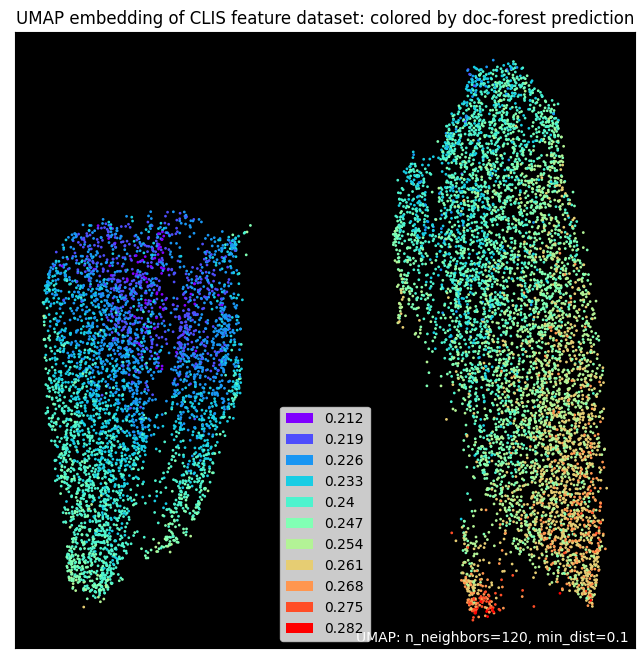

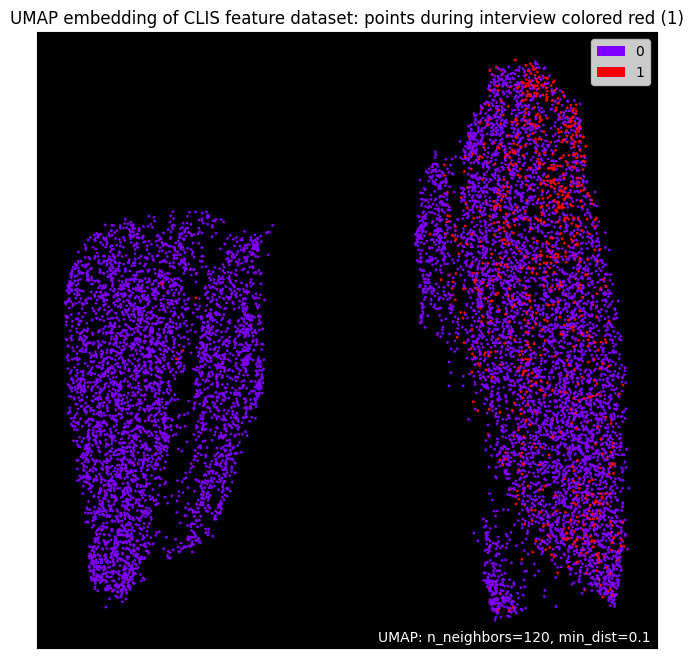

In [14]:
subplot_pred = umap.plot.points(mapper,
                                labels=pd.cut(df_pred_[1], 11, labels=np.round_(
                                    np.linspace(df_pred_[1].min(), df_pred_[1].max(), 11), 3)),
                                theme="fire")
subplot_pred.set_title(
    "UMAP embedding of CLIS feature dataset: colored by doc-forest prediction")

s_interview = pd.Series(0, index=df_pred_.index)
s_interview[start: end] = 1

subplot_interview = umap.plot.points(mapper, labels=s_interview, theme="fire")
subplot_interview.set_title(
    "UMAP embedding of CLIS feature dataset: points during interview colored red (1)")

<AxesSubplot:>

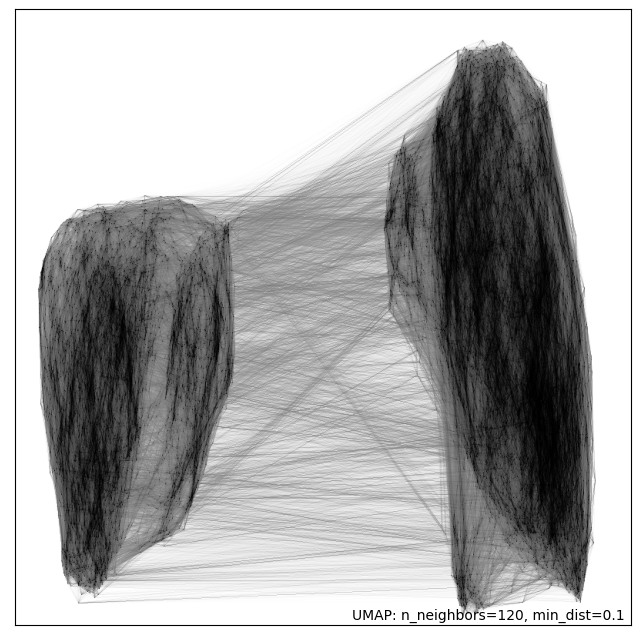

In [15]:
umap.plot.connectivity(mapper, show_points=False)